In [2]:
import re
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoProcessor
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

In [3]:
data = load_dataset('derek-thomas/ScienceQA', split='train') # choose the test set

In [ ]:
from datasets import load_dataset

def build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                 split='train',
                                 keep_grades='1-6'):
    """
    构建按年级过滤的测试数据集（不限制样本数量）。

    参数:
        dataset_name (str): 数据集名称，例如 'derek-thomas/ScienceQA'。
        split (str): 数据分割，例如 'train', 'test', 'validation'。
        keep_grades (str or None): 筛选的年级段："1-6"、"7-12" 或 None 表示不过滤。

    返回:
        List[Dict]: 筛选后的样本列表。
    """

    def is_grade_allowed(grade_str):
        if keep_grades is None:
            return True
        try:
            grade_num = int(grade_str.replace("grade", ""))
            if keep_grades == "1-6":
                return 1 <= grade_num <= 6
            elif keep_grades == "7-12":
                return 7 <= grade_num <= 12
        except:
            return False
        return False

    data = load_dataset(dataset_name, split=split)
    test_dataset = []

    for i, sample in enumerate(data):
        try:
            if sample.get('question') is None:
                continue

            if not is_grade_allowed(sample.get("grade", "")):
                continue

            solution = sample.get("solution", "")
            lecture = sample.get("lecture", "")
            solution_lecture = f"{solution}\n\n{lecture}".strip()

            test_dataset.append({
                "image": sample.get("image", None), 
                "question": sample["question"],
                "choices": sample["choices"],
                "hint": sample["hint"],
                "answer": sample["answer"],
                "solution_lecture": solution_lecture,
                'grade':sample["grade"],
            })

        except Exception as e:
            print(f"跳过第 {i} 个样本，错误：{e}")
            continue

    return test_dataset

In [5]:
data = build_filtered_test_dataset(dataset_name='derek-thomas/ScienceQA',
                                    split='train',
                                    keep_grades='1-6')

8344
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=152x152 at 0x7F506201B190>, 'question': 'What does pollen help a plant do?', 'choices': ['make seeds', 'grow bigger', 'grow new leaves'], 'hint': 'The male part of a flower makes pollen.', 'answer': 0, 'solution_lecture': 'Pollen helps the flower make seeds. After pollination, sperm cells from the pollen can combine with the eggs. These fertilized eggs can grow into seeds.\nPollen does not help a plant grow bigger or grow leaves.\n\nMany plants have flowers. These plants can use their flowers to reproduce, or make new plants like themselves. How do plants use their flowers to reproduce?\nFirst, the male part of the flower makes pollen, and the female part makes eggs. Animals, wind, or water can move pollen. Pollination is what happens when pollen is moved to the female part of the flower.\nAfter pollination, sperm from the pollen can combine with the eggs. This is called fertilization. The fertilized eggs grow into see

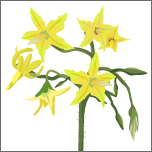

In [17]:
n = 7
print (len(data))
print (data[n])
display(data[n]["image"])

In [7]:
def build_message(sample):
    content = []
    if sample['image'] is not None:
        content.append({"type": "image", "image": sample['image']})
    
    question_text = f"Question: {sample['question']}\nChoices:\n"
    for idx, choice in enumerate(sample['choices']):
        question_text += f"{chr(65 + idx)}. {choice}\n"
    
    if sample.get("hint"):
        question_text += f"\nHint: {sample['hint']}\n"
    
    question_text += ("\nPlease select the correct answer. "
        "Then, explain your reasoning in detail. "
        "Make sure your explanation is at least three sentences long, "
        "refers to specific data from the image, and shows your step-by-step logic.")
    content.append({"type": "text", "text": question_text})
    
    return [{"role": "user", "content": content}]

[{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=152x152 at 0x7F506201B190>}, {'type': 'text', 'text': 'Question: What does pollen help a plant do?\nChoices:\nA. make seeds\nB. grow bigger\nC. grow new leaves\n\nHint: The male part of a flower makes pollen.\n\nPlease select the correct answer. Then, explain your reasoning in detail. Make sure your explanation is at least three sentences long, refers to specific data from the image, and shows your step-by-step logic.'}]}]


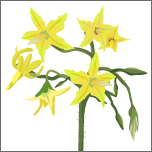

In [8]:
n = 7
print (build_message(data[n]))
display(data[n]["image"])

In [9]:
def parse_output(output):
    output = output.strip()
    answer_match = re.search(r"\b([A-D])[\.\:]", output)
    if answer_match:
        answer = ord(answer_match.group(1)) - 65
    else:
        answer = -1
    explanation = ""
    if answer != -1:
        idx = output.find(answer_match.group(0))
        if idx != -1:
            explanation = output[idx + len(answer_match.group(0)):].strip()
    return answer, explanation

# 准备结束正式开始

In [1]:
import torch
from transformers import (
    AutoProcessor,
    AutoModelForVision2Seq,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq,
)
from datasets import load_dataset, Dataset
from peft import PrefixTuningConfig, get_peft_model
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import re

# 1. 加载并按年级过滤 ScienceQA 数据集
raw_train = load_dataset('derek-thomas/ScienceQA', split='train')
raw_val   = load_dataset('derek-thomas/ScienceQA', split='validation')

def is_grade_allowed(grade_str, keep='1-6'):
    try:
        num = int(grade_str.replace('grade',''))
        return 1 <= num <= 6 if keep=='1-6' else 7 <= num <= 12
    except:
        return False

def build_filtered_list(raw, keep_grades='1-6'):
    filtered = []
    for sample in raw:
        if sample.get('question') and is_grade_allowed(sample.get('grade',''), keep_grades):
            sol = sample.get('solution','')
            lec = sample.get('lecture','')
            filtered.append({
                'image': sample.get('image', None),
                'question': sample['question'],
                'choices': sample['choices'],
                'hint': sample.get('hint', None),
                'answer': sample['answer'],
                'solution_lecture': f"{sol}\n\n{lec}".strip()
            })
    return filtered

train_list = build_filtered_list(raw_train, keep_grades='1-6')
val_list   = build_filtered_list(raw_val,   keep_grades='1-6')

train_ds = Dataset.from_list(train_list)
val_ds   = Dataset.from_list(val_list)

# 2. 加载模型和处理器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForVision2Seq.from_pretrained(
    'Qwen/Qwen2.5-VL-7B-Instruct',
    device_map='auto',
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
processor = AutoProcessor.from_pretrained('Qwen/Qwen2.5-VL-7B-Instruct')

# 3. 包装模型为 Prefix Tuning
peft_config = PrefixTuningConfig(
    task_type='SEQ_2_SEQ_LM',
    num_virtual_tokens=30,
    prefix_projection=True,
)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 4. 定义预处理函数
max_input_length = 512
max_target_length = 128

smooth = SmoothingFunction().method1
rouge = Rouge()

letter2idx = {"A":0,"B":1,"C":2,"D":3}

def preprocess_fn(ex):
    # 构造 chat 输入
    content = []
    if ex['image']:
        content.append({'type':'image','image':ex['image']})
    prompt = f"Question: {ex['question']}\nChoices:\n"
    for i, ch in enumerate(ex['choices']):
        prompt += f"{chr(65+i)}. {ch}\n"
    if ex.get('hint'):
        prompt += f"\nHint: {ex['hint']}\n"
    prompt += "\nPlease select the correct answer and explain why."
    content.append({'type':'text','text':prompt})

    chat = processor.apply_chat_template(
        [{'role':'user','content':content}],
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = processor(
        text=[chat],
        images=[ex['image']] if ex['image'] else None,
        padding='max_length',
        truncation=True,
        max_length=max_input_length,
        return_tensors='pt'
    )

    # 构造标签：字母 + 解释
    letter = chr(65 + ex['answer'])
    target = f"{letter}. {ex['solution_lecture']}"
    labels = processor.tokenizer(
        target,
        padding='max_length',
        truncation=True,
        max_length=max_target_length,
        return_tensors='pt'
    ).input_ids[0]
    labels[labels == processor.tokenizer.pad_token_id] = -100
    inputs['labels'] = labels
    return {k: v[0] for k, v in inputs.items()}

train_enc = train_ds.map(preprocess_fn, remove_columns=list(train_ds.column_names)).with_format('torch')
val_enc   = val_ds.map(preprocess_fn,   remove_columns=list(val_ds.column_names)).with_format('torch')

# 5. 定义 compute_metrics

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = processor.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)

    # 分类准确率
    pred_letters = [p.strip()[0] if p else '' for p in decoded_preds]
    true_letters = [l.strip()[0] if l else '' for l in decoded_labels]
    y_pred = [letter2idx.get(x, -1) for x in pred_letters]
    y_true = [letter2idx.get(x, -1) for x in true_letters]
    acc = accuracy_score(y_true, y_pred)

    # 解释质量指标
    bleu1_scores = []
    rouge_l_scores = []
    for p, l in zip(decoded_preds, decoded_labels):
        # 去掉“X. ”前缀再评估
        p_expl = p[2:].split()
        l_expl = l[2:].split()
        bleu1_scores.append(sentence_bleu([l_expl], p_expl, weights=(1,0,0,0), smoothing_function=smooth))
        r = rouge.get_scores(' '.join(p_expl), ' '.join(l_expl))[0]['rouge-l']['f']
        rouge_l_scores.append(r)
    avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores)
    avg_rouge = sum(rouge_l_scores) / len(rouge_l_scores)

    return {
        'accuracy': acc,
        'bleu1': avg_bleu1,
        'rouge-l': avg_rouge,
    }

# 6. DataCollator
collator = DataCollatorForSeq2Seq(
    tokenizer=processor.tokenizer,
    model=model,
    label_pad_token_id=-100
)

# 7. 训练参数 & Trainer
training_args = TrainingArguments(
    output_dir='./qwen_prefix_tuning',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps=500,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_enc,
    eval_dataset=val_enc,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

# 8. 开始训练 & 保存前缀权重
trainer.train()
model.save_pretrained('./qwen_prefix_tuning_prefix_only')

/root/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-10 12:03:44.455965: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 12:03:44.556937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 12:03:44.556974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-10 12:03:44.560008: E exte

trainable params: 14,986,752 || all params: 8,307,153,408 || trainable%: 0.1804


Map:  12%|█▏        | 999/8344 [00:11<01:21, 89.79 examples/s] 


KeyError: 'pixel_values'